# How to Interpolate?

In [6]:
#dataframes
import pandas as pd
import h5py
# import rosbag_pandas

#math
import numpy as np
import math
pd.TimeSeries = pd.Series 

#interpolation scipy
import scipy
from scipy import signal
import scipy.interpolate as interpolate
from scipy import integrate

#gps
from geopy import distance
import geopandas as gpd
import utm
import datetime as dt

#plots
import pylab as plt
import matplotlib.pyplot as plt
import matplotlib.animation as animation  



### Using Rosbag Pandas to import Bag

In [2]:
def clean_df(df):
    df.columns=df.columns.str.replace(r"/", "_")
    df = df[df.columns.drop(list(df.filter(regex='covariance')))]
    df = df[df.columns.drop(list(df.filter(regex='frame_id')))]
    df = df[df.columns.drop(list(df.filter(regex='twist_twist_angular')))]
    df = df[df.columns.drop(list(df.filter(regex='seq')))]
    return df
def rosbag_to_pandas(filename, topics):  
    d = {name: pd.DataFrame() for name in topics}
    data = []
    for name,df in d.items():
        df = rosbag_pandas.bag_to_dataframe(filename, include=[name])
        df = clean_df(df)
        data.append(df)
    data=pd.concat(data)
    return data

In [5]:
run = 4
for i in range(0,6):
    set_number = i
    filename = '/home/ecc/data/BagsOctober/Run0'+str(run)+'/OctoberDesert1020_'+str(set_number)+'.bag'
    topics = ('/trisonica','/analog_output','/ublox_gps/fix', '/ublox_gps/fix_velocity','/imu/data')
    df= rosbag_to_pandas(filename, topics)
    df = df.reset_index()
    df = df.rename(columns={"index": "master_time"})
    df.to_hdf('/home/ecc/data/DesertDataOct/Run0'+str(run)+'/Run0'+str(run)+
              'Set0'+str(set_number)+'.h5', key='df', mode='w')
# df.keys()

### Load Data

In [46]:
data = []
run = 4
for i in range(0,6):
    set_number = i 
    f_name = '/home/ecc/data/DesertDataOct/Run0'+str(run)+'/Run0'+str(run)+'Set0'+str(set_number)+'.h5'    
    df = pd.read_hdf(f_name)
    data.append(df)
df=pd.concat(data)    

In [41]:
df = pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Forest/Sprint01/ForestDataJuly_S1.h5')

## Interpolation

### Getting the GPS and WindSensor Time

In [42]:
df["trisonica_time"] = df._trisonica_header_stamp_secs + (df._trisonica_header_stamp_nsecs*1e-9)
df["gps_time"] = df._ublox_gps_fix_header_stamp_secs+(df._ublox_gps_fix_header_stamp_nsecs*1e-9)
df["gps_vel_time"] = df._ublox_gps_fix_velocity_header_stamp_secs+(df._ublox_gps_fix_velocity_header_stamp_nsecs*1e-9)
df["imu_time"] = df._imu_data_header_stamp_secs +(df._imu_data_header_stamp_nsecs*1e-9)

### Separating ODOR, WIND, GPS in dataframes

In [43]:
df_odor = pd.DataFrame({'odor_time': df.master_time,
                        'odor': df._analog_output_data,})
df_wind = pd.DataFrame({'wind_time': df.trisonica_time,'trisonica_U': df._trisonica_westeast,
                        'trisonica_V': df._trisonica_northsouth,'trisonica_pressure': df._trisonica_pressure,
                       'trisonica_temperature': df._trisonica_temperature})
df_gps = pd.DataFrame({'gps_time': df.gps_time,'lat': df._ublox_gps_fix_latitude,
                       'lon': df._ublox_gps_fix_longitude})
df_gps_vel = pd.DataFrame({'gps_vel_time':df.gps_vel_time,
                        'gps_linear_x':df._ublox_gps_fix_velocity_twist_twist_linear_x,
                      'gps_linear_y':df._ublox_gps_fix_velocity_twist_twist_linear_y,
                      'gps_linear_z':df._ublox_gps_fix_velocity_twist_twist_linear_z})
df_imu = pd.DataFrame({'imu_time': df.imu_time,'imu_angular_x': df._imu_data_angular_velocity_x,
                     'imu_angular_y': df._imu_data_angular_velocity_y, 
                     'imu_angular_z':df._imu_data_angular_velocity_z,
                      'imu_linear_acc_x':df._imu_data_linear_acceleration_x,
                      'imu_linear_acc_y':df._imu_data_linear_acceleration_y,
                      'imu_linear_acc_z':df._imu_data_linear_acceleration_z})

#### Creating time column for odor by dropping NaNs

In [44]:
df_odor = df_odor[df_odor.odor.notna()]

### Combined time from three sensors and arrange based on time

In [45]:
dfn = pd.concat([df_odor, df_wind, df_gps, df_gps_vel, df_imu], sort=True)
combined_time = np.hstack([df_odor.odor_time, df.trisonica_time ,df.gps_time, df.gps_vel_time, df.imu_time])
dfn['time'] = combined_time
dfn = dfn.sort_values(by=['time'])

In [46]:
dfn.keys()

Index(['gps_linear_x', 'gps_linear_y', 'gps_linear_z', 'gps_time',
       'gps_vel_time', 'imu_angular_x', 'imu_angular_y', 'imu_angular_z',
       'imu_linear_acc_x', 'imu_linear_acc_y', 'imu_linear_acc_z', 'imu_time',
       'lat', 'lon', 'odor', 'odor_time', 'trisonica_U', 'trisonica_V',
       'trisonica_pressure', 'trisonica_temperature', 'wind_time', 'time'],
      dtype='object')

### Find Master Time 

In [47]:
dt_odor = np.median(np.diff(dfn.odor_time.dropna().values))
print('dt Odor: ', dt_odor)
dt_wind = np.median(np.diff(dfn.wind_time.dropna().values))
print('dt Wind: ', dt_wind)
dt_gps = np.median(np.diff(dfn.gps_time.dropna().values))
print('dt Gps: ', dt_gps)
dt_gps_vel = np.median(np.diff(dfn.gps_vel_time.dropna().values))
print('dt Gps Vel: ', dt_gps_vel)
dt_imu = np.median(np.diff(dfn.imu_time.dropna().values))
print('dt Imu: ', dt_imu)
first_time = np.max([dfn.odor_time.min(), dfn.wind_time.min(), dfn.gps_vel_time.min(),
                     dfn.gps_time.min(), dfn.imu_time.min()])
last_time = np.min([dfn.odor_time.max(), dfn.wind_time.max(), dfn.gps_time.max(),
                    dfn.gps_vel_time.max(),dfn.imu_time.max()])
# print(first_time,last_time)
master_time = np.arange(first_time, last_time, dt_odor)

dt Odor:  0.004995584487915039
dt Wind:  0.025004148483276367
dt Gps:  0.19999980926513672
dt Gps Vel:  0.19999980926513672
dt Imu:  0.003999948501586914


In [48]:
dfn.keys()

Index(['gps_linear_x', 'gps_linear_y', 'gps_linear_z', 'gps_time',
       'gps_vel_time', 'imu_angular_x', 'imu_angular_y', 'imu_angular_z',
       'imu_linear_acc_x', 'imu_linear_acc_y', 'imu_linear_acc_z', 'imu_time',
       'lat', 'lon', 'odor', 'odor_time', 'trisonica_U', 'trisonica_V',
       'trisonica_pressure', 'trisonica_temperature', 'wind_time', 'time'],
      dtype='object')

### Create Interpolation function

In [49]:
# create interpolation function and inteprolate sensor 1
df_odor_1= dfn[['odor_time', 'odor']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_odor_1.odor_time, df_odor_1.odor)
interp_odor = func_interp_sensor_1(master_time)

df_wind_1= dfn[['wind_time', 'trisonica_U']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_1.wind_time, df_wind_1.trisonica_U)
interp_wind_U = func_interp_sensor_1(master_time)

df_wind_2= dfn[['wind_time', 'trisonica_V']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_2.wind_time, df_wind_2.trisonica_V)
interp_wind_V = func_interp_sensor_1(master_time)

df_wind_3= dfn[['wind_time', 'trisonica_pressure']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_3.wind_time, df_wind_3.trisonica_pressure)
interp_wind_p = func_interp_sensor_1(master_time)

df_wind_4= dfn[['wind_time', 'trisonica_temperature']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_4.wind_time, df_wind_4.trisonica_temperature)
interp_wind_t = func_interp_sensor_1(master_time)


df_gps_lat= dfn[['gps_time', 'lat']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_gps_lat.gps_time, df_gps_lat.lat)
interp_gps_lat = func_interp_sensor_1(master_time)

df_gps_lon= dfn[['gps_time', 'lon']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_gps_lon.gps_time, df_gps_lon.lon)
interp_gps_lon = func_interp_sensor_1(master_time)

df_gps_x= dfn[['gps_vel_time', 'gps_linear_x']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_gps_x.gps_vel_time, df_gps_x.gps_linear_x)
interp_gps_x = func_interp_sensor_1(master_time)

df_gps_y= dfn[['gps_vel_time', 'gps_linear_y']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_gps_y.gps_vel_time, df_gps_y.gps_linear_y)
interp_gps_y = func_interp_sensor_1(master_time)

df_gps_z= dfn[['gps_vel_time', 'gps_linear_z']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_gps_z.gps_vel_time, df_gps_z.gps_linear_z)
interp_gps_z = func_interp_sensor_1(master_time)


df_imu_x= dfn[['imu_time', 'imu_angular_x']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_x.imu_time, df_imu_x.imu_angular_x)
interp_imu_x = func_interp_sensor_1(master_time)

df_imu_y= dfn[['imu_time', 'imu_angular_y']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_y.imu_time, df_imu_y.imu_angular_y)
interp_imu_y = func_interp_sensor_1(master_time)


df_imu_z= dfn[['imu_time', 'imu_angular_z']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_z.imu_time, df_imu_z.imu_angular_z)
interp_imu_z = func_interp_sensor_1(master_time)


df_imu_linear_x= dfn[['imu_time', 'imu_linear_acc_x']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_linear_x.imu_time, df_imu_linear_x.imu_linear_acc_x)
interp_imu_linear_acc_x = func_interp_sensor_1(master_time)

df_imu_linear_y= dfn[['imu_time', 'imu_linear_acc_y']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_linear_y.imu_time, df_imu_linear_y.imu_linear_acc_y)
interp_imu_linear_acc_y = func_interp_sensor_1(master_time)


df_imu_linear_z= dfn[['imu_time', 'imu_linear_acc_z']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_linear_z.imu_time, df_imu_linear_z.imu_linear_acc_z)
interp_imu_linear_acc_z = func_interp_sensor_1(master_time)





### New Interpolated Dataframe

In [50]:
odor = pd.DataFrame({'master_time': master_time,
                        'odor': interp_odor,
                        'trisonica_U': interp_wind_U,
                        'trisonica_V': interp_wind_V,
                        'lat': interp_gps_lat,
                        'lon': interp_gps_lon,
                        'gps_linear_x':interp_gps_x,
                        'gps_linear_y':interp_gps_y,
                        'gps_linear_z':interp_gps_z,
                        'trisonica_pressure':interp_wind_p,
                        'trisonica_temperature':interp_wind_t,
                        'imu_angular_x': interp_imu_x,
                        'imu_angular_y': interp_imu_y,
                        'imu_angular_z': interp_imu_z,
                        'imu_linear_acc_x':interp_imu_linear_acc_x,
                        'imu_linear_acc_y':interp_imu_linear_acc_y,
                        'imu_linear_acc_z':interp_imu_linear_acc_z})

# odor.to_hdf('/home/ecc/data/DesertDataOct/Run01/Run01_Interpolated.h5',key='df', mode='w')

## Interpolating Wind and Odor

In [58]:
#ubuntu
# fname='~/data/DesertDataOct/StationeryWind/20201020_172919_windy_b_data.hdf'
fname='~/Documents/Myfiles/DataAnalysis/data/Sprints/Forest/Sprint01/WindStationA.hdf'
#mac 
# fname = '~/Documents/Myfiles/DataAnalysis/data/20201020_172919_windy_b_data.hdf'
wind_df=pd.read_hdf(fname)
# wind_df.keys()
wind_df.reset_index(inplace=True, drop=True) 
wind =pd.DataFrame()
wind = wind_df.loc[(wind_df.time_epoch >= odor.master_time.iloc[0]) & 
                   (wind_df.time_epoch <= odor.master_time.iloc[-1])]
# df2.to_hdf('/home/ecc/data/DesertDataOct/Run01/Wind01.h5', key='df2', mode='w')

### Converting lat lon information to meters

In [59]:
from shapely.geometry import Point
odor['geometry'] = odor.apply(lambda row: Point(row.lon, row.lat), axis=1)

geodf = gpd.GeoDataFrame(odor)
geodf.crs= {'init': 'epsg:4326'}
# change the projection of geodf
geodf = geodf.to_crs("+proj=utm +zone=11 +ellps=WGS84 +datum=WGS84 +units=m +no_def")

geodf["x"] = geodf.geometry.apply(lambda row:row.x)
geodf["y"] = geodf.geometry.apply(lambda row:row.y)

#source location to meters
# source = (40.79376709443614, -119.15757512132207)
source =(39.252441,-119.878037)
# u =  utm.from_latlon(40.79376709443614, -119.15757512132207)
u =  utm.from_latlon(39.252441, -119.878037)
xfromsrc= geodf.x-u[0]
geodf.insert(9,'xsrc',xfromsrc) 

yfromsrc = geodf.y-u[1]
geodf.insert(10,'ysrc', yfromsrc)

/Users/an/Documents/MyFiles/DataAnalysis/FlyDataAnalysis/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [23]:
wind.keys()

Index(['millis', 'lat', 'lon', 'gps_time', 'gps_date', 'wind', 'gps_date_str',
       'year', 'month', 'day', 'gps_time_str', 'hour', 'minute', 'second',
       'time_epoch', 'S2', 'D', 'U', 'V'],
      dtype='object')

### Interpolate

In [60]:
df_odor_loc=pd.DataFrame({'odor_time': geodf.master_time,'xsrc': geodf.xsrc, 'ysrc':geodf.ysrc, 
                          'odor':geodf.odor,
                          'trisonica_U':geodf.trisonica_U, 'trisonica_V':geodf.trisonica_V,
                          'trisonica_temperature':geodf.trisonica_temperature,
                          'trisonica_pressure':geodf.trisonica_pressure,
                          'gps_linear_x':geodf.gps_linear_x,
                          'gps_linear_y':geodf.gps_linear_y,
                          'gps_linear_z':geodf.gps_linear_z,
                          'imu_angular_x': geodf.imu_angular_x,
                          'imu_angular_y': geodf.imu_angular_y,
                          'imu_angular_z': geodf.imu_angular_z,
                          'imu_linear_acc_x':geodf.imu_linear_acc_z,
                          'imu_linear_acc_y':geodf.imu_linear_acc_z,
                          'imu_linear_acc_z':geodf.imu_linear_acc_z
                         })
df_wind_loc=pd.DataFrame({'wind_time': wind.time_epoch,'U': wind.U,'V': wind.V, 'D':wind.D , 'S2':wind.S2})


df_new = pd.concat([df_odor_loc,df_wind_loc], sort=True)
combined_time = np.hstack([df_odor_loc.odor_time, df_wind_loc.wind_time])

df_new['time'] = combined_time
df_new=df_new.sort_values(by=['time'])

dt_odor = np.median(np.diff(df_new.odor_time.dropna().values))
print('dt Odor: ', dt_odor)
dt_wind = np.median(np.diff(df_new.wind_time.dropna().values))
print('dt Wind: ', dt_wind)

first_time = np.max([df_new.odor_time.min(), df_new.wind_time.min()])
last_time = np.min([df_new.odor_time.max(), df_new.wind_time.max()])
############## SELECT THE RESOLUTION HERE ####################
master_time = np.arange(first_time, last_time, dt_odor)

# create interpolation function and inteprolate sensor 1
df_odor_1= df_new[['odor_time', 'xsrc']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_odor_1.odor_time, df_odor_1.xsrc)
interp_odor_x = func_interp_sensor_1(master_time)

df_odor_2= df_new[['odor_time', 'ysrc']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_odor_2.odor_time, df_odor_2.ysrc)
interp_odor_y = func_interp_sensor_1(master_time)

df_odor_3= df_new[['odor_time', 'odor']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_odor_3.odor_time, df_odor_3.odor)
interp_odor = func_interp_sensor_1(master_time)

df_gps_x= df_new[['odor_time', 'gps_linear_x']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_gps_x.odor_time, df_gps_x.gps_linear_x)
interp_gps_x = func_interp_sensor_1(master_time)

df_gps_y= df_new[['odor_time', 'gps_linear_y']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_gps_y.odor_time, df_gps_y.gps_linear_y)
interp_gps_y = func_interp_sensor_1(master_time)

df_gps_z= df_new[['odor_time', 'gps_linear_z']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_gps_z.odor_time, df_gps_z.gps_linear_z)
interp_gps_z = func_interp_sensor_1(master_time)



df_wind_1x= df_new[['odor_time', 'trisonica_U']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_1x.odor_time, df_wind_1x.trisonica_U)
interp_wind_Ux = func_interp_sensor_1(master_time)

df_wind_2x= df_new[['odor_time', 'trisonica_V']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_2x.odor_time, df_wind_2x.trisonica_V)
interp_wind_Vx = func_interp_sensor_1(master_time)

df_wind_3x= df_new[['odor_time', 'trisonica_pressure']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_3x.odor_time, df_wind_3x.trisonica_pressure)
interp_wind_px = func_interp_sensor_1(master_time)

df_wind_4x= df_new[['odor_time', 'trisonica_temperature']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_4x.odor_time, df_wind_4x.trisonica_temperature)
interp_wind_tx = func_interp_sensor_1(master_time)

df_imu_x= df_new[['odor_time', 'imu_angular_x']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_x.odor_time, df_imu_x.imu_angular_x)
interp_imu_x = func_interp_sensor_1(master_time)

df_imu_y= df_new[['odor_time', 'imu_angular_y']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_y.odor_time, df_imu_y.imu_angular_y)
interp_imu_y = func_interp_sensor_1(master_time)


df_imu_z= df_new[['odor_time', 'imu_angular_z']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_z.odor_time, df_imu_z.imu_angular_z)
interp_imu_z = func_interp_sensor_1(master_time)


df_imu_linear_x= df_new[['odor_time', 'imu_linear_acc_x']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_linear_x.odor_time, df_imu_linear_x.imu_linear_acc_x)
interp_imu_linear_acc_x = func_interp_sensor_1(master_time)

df_imu_linear_y= df_new[['odor_time', 'imu_linear_acc_y']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_linear_y.odor_time, df_imu_linear_y.imu_linear_acc_y)
interp_imu_linear_acc_y = func_interp_sensor_1(master_time)


df_imu_linear_z= df_new[['odor_time', 'imu_linear_acc_z']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_linear_z.odor_time, df_imu_linear_z.imu_linear_acc_z)
interp_imu_linear_acc_z = func_interp_sensor_1(master_time)




df_wind_1= df_new[['wind_time', 'U']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_1.wind_time, df_wind_1.U)
interp_wind_U = func_interp_sensor_1(master_time)

df_wind_2= df_new[['wind_time', 'V']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_2.wind_time, df_wind_2.V)
interp_wind_V = func_interp_sensor_1(master_time)

df_wind_3= df_new[['wind_time', 'D']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_3.wind_time, df_wind_3.D)
interp_wind_D = func_interp_sensor_1(master_time)

df_wind_4= df_new[['wind_time', 'S2']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_4.wind_time, df_wind_4.S2)
interp_wind_S2 = func_interp_sensor_1(master_time)



windn = pd.DataFrame({'master_time': master_time,
                            'xsrc': interp_odor_x,
                            'ysrc': interp_odor_y,
                            'odor': interp_odor,
                            'trisonica_u': interp_wind_Ux,
                            'trisonica_v': interp_wind_Vx,
                            'trisonica_pressure':interp_wind_px,
                            'trisonica_temperature':interp_wind_tx,
                            'gps_linear_x': interp_gps_x,
                            'gps_linear_y': interp_gps_y,
                            'gps_linear_z': interp_gps_z,
                            'imu_angular_x': interp_imu_x,
                            'imu_angular_y': interp_imu_y,
                            'imu_angular_z': interp_imu_z,
                            'imu_linear_acc_x':interp_imu_linear_acc_x,
                            'imu_linear_acc_y':interp_imu_linear_acc_y,
                            'imu_linear_acc_z':interp_imu_linear_acc_z,
                      
                            'U': interp_wind_U,
                            'V': interp_wind_V,
                            'D':interp_wind_D,
                            'S2':interp_wind_S2})

# windn.to_hdf('/home/ecc/data/DesertDataOct/Run0'+str(run)+'/Run0'+str(run)+'.h5',key='windn', mode='w')
windn.to_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Forest/Sprint01/Sprint01Interpolated.h5', key='windn', mode='w')

dt Odor:  0.004995584487915039
dt Wind:  0.10000252723693848


In [36]:
windn

,master_time,xsrc,ysrc,odor,trisonica_u,trisonica_v,trisonica_pressure,trisonica_temperature,gps_linear_x,gps_linear_y,...,imu_angular_x,imu_angular_y,imu_angular_z,imu_linear_acc_x,imu_linear_acc_y,imu_linear_acc_z,U,V,D,S2
0,1.625681e+09,-66321.133850,-169364.078022,-0.834685,-0.048443,1.692265,807.400024,15.408160,0.001950,0.026226,...,0.000045,-0.004999,0.000476,-9.848695,-9.848695,-9.848695,2.544000,1.025000,248.000000,2.743000
1,1.625681e+09,-66321.133850,-169364.078022,-0.833969,-0.048104,1.708776,807.400024,15.413723,0.001620,0.025321,...,-0.000033,-0.005677,0.003097,-9.845272,-9.845272,-9.845272,2.542052,1.027498,247.950045,2.742151
2,1.625681e+09,-66321.133850,-169364.078022,-0.834344,-0.046111,1.728890,807.400024,15.417778,0.000915,0.024018,...,-0.000013,-0.005449,-0.000390,-9.835802,-9.835802,-9.835802,2.540104,1.029995,247.900091,2.741302
3,1.625681e+09,-66321.133850,-169364.078022,-0.835283,-0.044094,1.749056,807.400024,15.421811,0.000191,0.022694,...,0.000019,-0.005971,-0.002723,-9.831998,-9.831998,-9.831998,2.538155,1.032493,247.850136,2.740452
4,1.625681e+09,-66321.133850,-169364.078022,-0.834570,-0.042078,1.769221,807.400024,15.425844,-0.000533,0.021370,...,0.000091,-0.006194,-0.006287,-9.834052,-9.834052,-9.834052,2.536207,1.034991,247.800182,2.739603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227137,1.625682e+09,-66321.928185,-169363.248310,-0.731318,0.360168,1.519829,807.299988,15.615085,-0.003397,-0.050898,...,0.004498,-0.006786,-0.014681,-9.879289,-9.879289,-9.879289,3.025670,-0.227613,274.216598,3.034753
227138,1.625682e+09,-66321.928176,-169363.248033,-0.731435,0.505197,1.609231,807.299988,15.628992,-0.003421,-0.050198,...,0.003797,-0.006633,-0.014555,-9.879044,-9.879044,-9.879044,3.040507,-0.225166,274.166643,3.049340
227139,1.625682e+09,-66321.928167,-169363.247755,-0.731419,0.578674,1.639375,807.299988,15.637504,-0.003446,-0.049499,...,0.002924,-0.006633,-0.010477,-9.877971,-9.877971,-9.877971,3.055343,-0.222718,274.116689,3.063927
227140,1.625682e+09,-66321.928158,-169363.247478,-0.731165,0.445735,1.498573,807.299988,15.630452,-0.003471,-0.048800,...,0.003515,-0.006291,-0.012941,-9.880116,-9.880116,-9.880116,3.070180,-0.220270,274.066734,3.078514


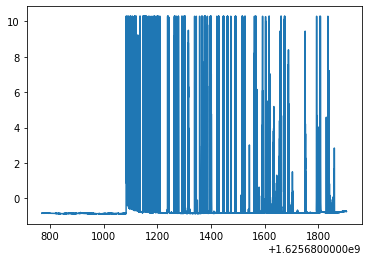

In [42]:
plt.plot(windn.master_time,windn.odor)